In [1]:
import sri_tabi_problem as sri  # TODO rename to sirlo
import toy_tabi_problem as toy

import pyro
import torch
import pyro.distributions as dist
from chirho.dynamical.ops import State
from collections import OrderedDict
from typing import (
    Union,
)
import matplotlib.pyplot as plt
from pyro.infer.autoguide import AutoNormal

import chirho.contrib.compexp as ep  # TODO rename to expectation_programming (?)

pyro.settings.set(module_local_params=True)

PT = torch.nn.Parameter
TT = torch.Tensor
tt = torch.tensor
UPTT = Union[PT, TT]

assert sri.LOCKDOWN_TYPE == sri.LockdownType.NONCONT_STATE

# Set true just to see if everything runs (a smoke test). Set false to run everything for full count of iterations.
SMOKE = False

In [2]:
def cost(s):
    return 1e1 * toy.cost(d=D, c=C, **s)

### TABI Estimation — Toy Problem

Here, we outline a toy TABI estimation problem, and show vastly improved sample efficiency over a monte-carlo implementation.

In [3]:
# Hyper parameter controlling how far the cost function sits in the tails.
C = tt(1.0)
# Hyper parameter representing a decision parameter. Cost is a function of this parameter.
D = tt(0.5)
# The ground truth for this problem can be seen at this desmos link: https://www.desmos.com/calculator/rjmtzdtbzq
GT = -1.1337

if not SMOKE:
    N = 33 * 3
    M = 500
else:
    N = 10
    M = 10

xx = torch.linspace(-5., 5., 100)

In [4]:
MODEL_DIST = dist.Normal(0., 1.)
def model():
    x = pyro.sample('x', MODEL_DIST)
    return OrderedDict(x=x)

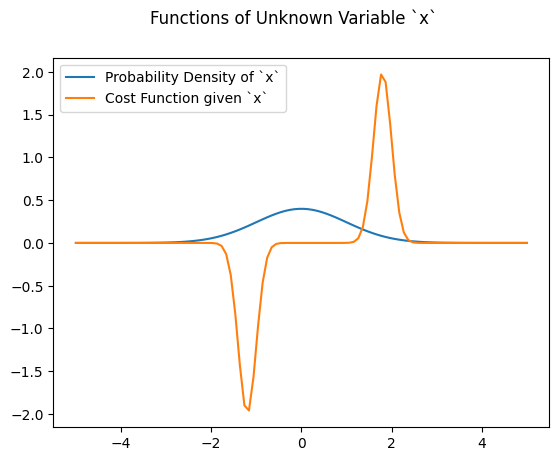

In [5]:
plt.figure()
plt.plot(xx, MODEL_DIST.log_prob(xx).exp(), label="Probability Density of `x`")
plt.plot(xx, toy.cost(d=D, x=xx, c=C), label="Cost Function given `x`")
plt.suptitle("Functions of Unknown Variable `x`")
plt.legend()


In [6]:
expectation_of_cost = ep.E(f=cost, name="cost")
mc_estimates_of_cost = []
for _ in range(M):
    with ep.MonteCarloExpectationHandler(num_samples=N):
        mc_estimates_of_cost.append(
            expectation_of_cost(model)
        )

[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>]

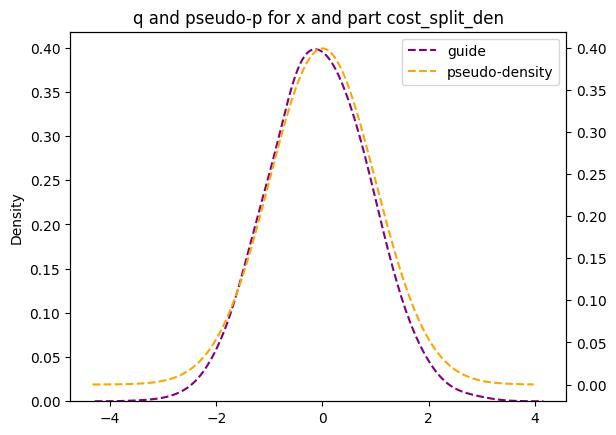

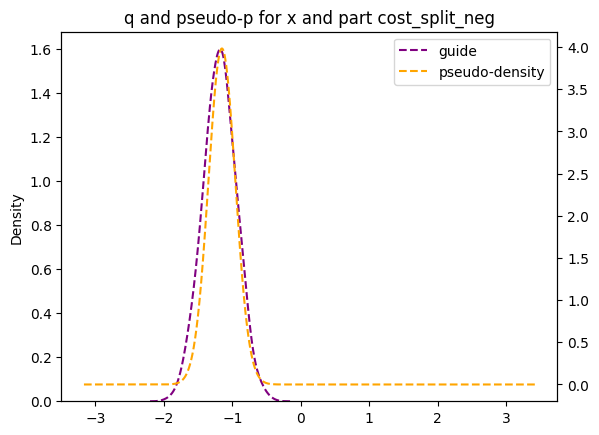

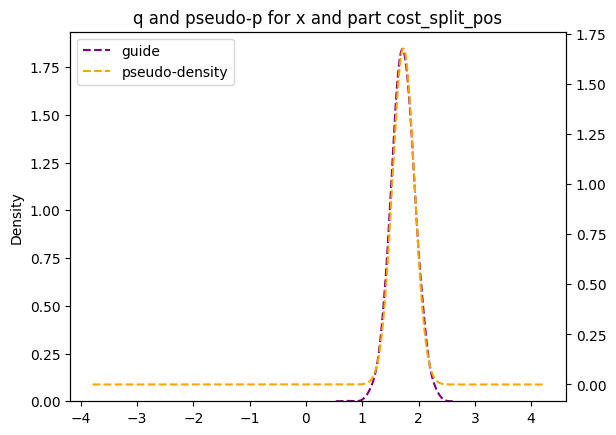

In [7]:
expectation_of_cost_tabi = expectation_of_cost.get_tabi_decomposition()

# TABI reduces to a particular decomposition of the expectation and importance sampling.
iseh = ep.ImportanceSamplingExpectationHandler(num_samples=N//3)

# Train the TABI proposal distributions.
iseh.register_guides(
    ce=expectation_of_cost_tabi,
    model=model,
    auto_guide=AutoNormal,
    auto_guide_kwargs=dict(init_scale=2.0)
)

# iseh.plot_guide_pseudo_likelihood(
#     rv_name='x',
#     guide_kde_kwargs=dict(bw_method=0.1),
#     pseudo_density_plot_kwargs=dict()
# )

losses1 = iseh.optimize_guides(
    lr=6e-3,
    n_steps=3000
)

iseh.plot_guide_pseudo_likelihood(
    rv_name='x',
    guide_kde_kwargs=dict(bw_method=0.3, linestyle='--', color='purple'),
    pseudo_density_plot_kwargs=dict(linestyle='--', color='orange'),
    n=3000
)

In [8]:
# Bootstrapped loss.
def bootstrap_estimate_with_elbo(losses, burnin=0):
    loss_estimates = []
    losses_conv = {k: torch.exp(-tt(v))[burnin:] for k, v in losses.items()}
    for _ in range(M):
        # Randomly choose a subset of N of the losses.
        losses_subset = {k: v[torch.randperm(len(v))[:(N//3)]] for k, v in losses_conv.items()}
        # Take the means of the susbet and combine pos, neg, and den.
        pos_est = losses_subset['cost_split_pos'].mean()
        neg_est = losses_subset['cost_split_neg'].mean()
        den_est = losses_subset['cost_split_den'].mean()
        loss_estimates.append((pos_est - neg_est) / den_est)
    return tt(loss_estimates)

In [9]:
print(expectation_of_cost_tabi)

((cost_split_pos + (-cost_split_neg)) / cost_split_den)


In [10]:
tabi_estimates_of_cost = []
for _ in range(M):
    with iseh:
        tabi_estimates_of_cost.append(
            expectation_of_cost_tabi(model)
        )

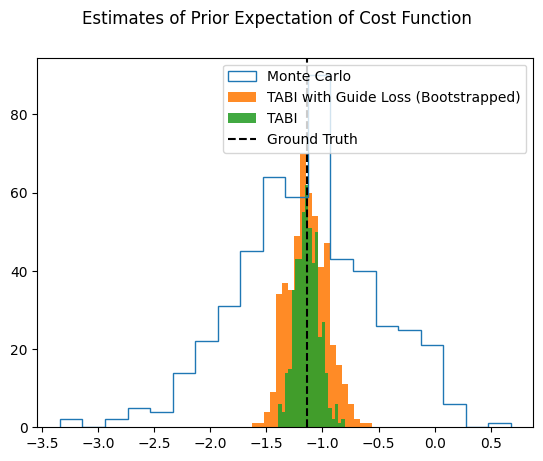

In [11]:
plt.figure()
plt.suptitle("Estimates of Prior Expectation of Cost Function")
plt.hist(mc_estimates_of_cost, bins=20, label="Monte Carlo", fill=False, histtype='step')
plt.hist(bootstrap_estimate_with_elbo(losses1, burnin=1500), bins=20, label="TABI with Guide Loss (Bootstrapped)", alpha=0.9)
plt.hist([v.detach() for v in tabi_estimates_of_cost], bins=20, label="TABI", alpha=0.9)
plt.axvline(GT, color='black', label="Ground Truth", linestyle='--')
plt.legend()

### Conditioning

Conditioning means that the density of the joint distribution over latents may not necessarily be evaluable directly. When utilizing importance sampling and the TABI decomposition, however, the normalizing constant of the conditioned model cancels in the TABI decomposition.

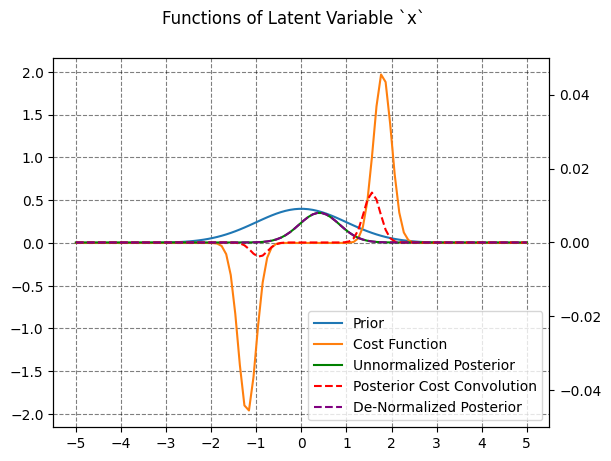

In [12]:
data = {'y': tt([0.5, 0.1, 0.8, 0.6])}

def conditionable_model():
    latents = model()
    with pyro.plate("data", len(data['y'])):
        y = pyro.sample('y', dist.Normal(latents['x'], 1.))
    return OrderedDict(**latents, y=y)

fig, ax = plt.subplots()
ax.plot(xx, MODEL_DIST.log_prob(xx).exp(), label="Prior")
ax.plot(xx, toy.cost(d=D, x=xx, c=C), label="Cost Function")

with pyro.condition(data=data):
    conditioned_density = [pyro.poutine.trace(pyro.condition(conditionable_model, data={'x': x_})).get_trace().log_prob_sum().exp() for x_ in xx]

    # * 5. just for visual scaling.
    conditioned_cost_conv = [pyro.poutine.trace(pyro.condition(conditionable_model, data={'x': x_})).get_trace().log_prob_sum().exp() * cost(dict(x=x_)) * 5. for x_ in xx]

tax = ax.twinx()
tax.plot(xx, conditioned_density, color='green', label="Unnormalized Posterior")
tax.plot(xx, conditioned_cost_conv, color='red', linestyle='--', label="Posterior Cost Convolution")
tax.set_ylim(-0.05, 0.05)

# Add grid lines.
ax.grid(True, linestyle='--', color='black', alpha=0.5)
# Make x-ticks be every integer.
from matplotlib.ticker import MultipleLocator
ax.xaxis.set_major_locator(MultipleLocator(1))

ANALYTIC_POSTERIOR_DIST = dist.Normal(0.4, 0.2**0.5)

tax.plot(xx, ANALYTIC_POSTERIOR_DIST.log_prob(xx).exp()*0.9e-2, linestyle='--', color='purple', label="De-Normalized Posterior")

plt.suptitle("Functions of Latent Variable `x`")

# Make a single legend for both axes.
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = tax.get_legend_handles_labels()
# Put the legend on the lower right.
tax.legend(lines + lines2, labels + labels2, loc='lower right')

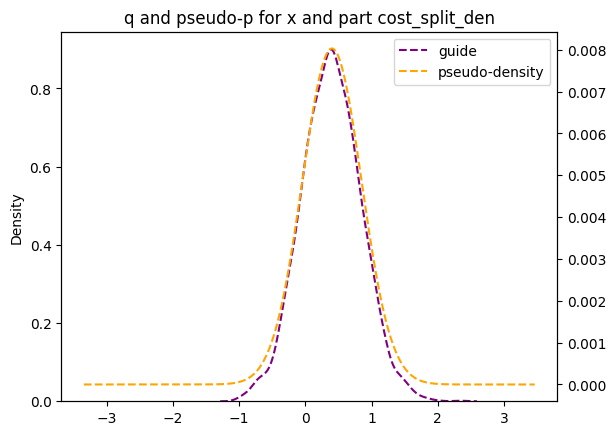

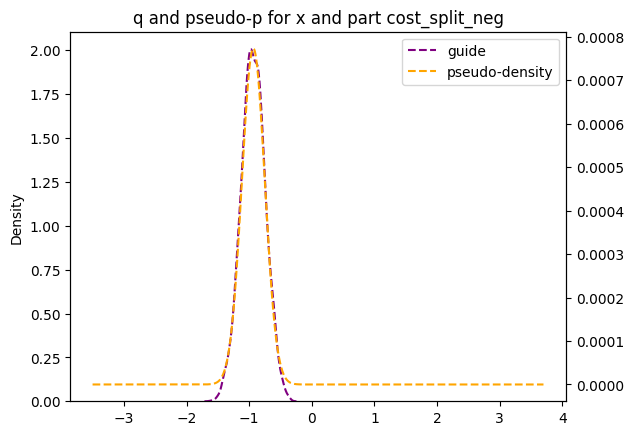

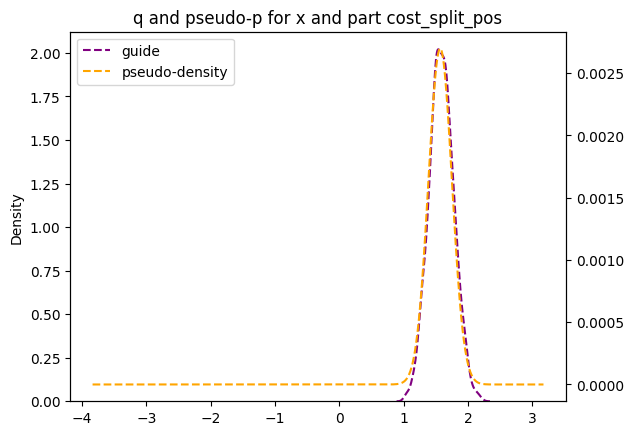

In [13]:
iseh_c = ep.ImportanceSamplingExpectationHandler(num_samples=N//3)

with pyro.condition(data=data):

    # Train the TABI proposal distributions.
    iseh_c.register_guides(
        ce=expectation_of_cost_tabi,
        model=conditionable_model,
        auto_guide=AutoNormal,
        auto_guide_kwargs=dict(init_scale=2.0),
        # This prevents the auto_guide from trying to sample observed data.
        auto_guide_model_wrap=lambda m: pyro.poutine.block(m, hide=['y'])
    )

    # iseh_c.plot_guide_pseudo_likelihood(
    #     rv_name='x',
    #     guide_kde_kwargs=dict(bw_method=0.3, linestyle='--', color='purple'),
    #     pseudo_density_plot_kwargs=dict(linestyle='--', color='orange')
    # )

    losses2 = iseh_c.optimize_guides(
        lr=6e-3,
        n_steps=3000
    )

    iseh_c.plot_guide_pseudo_likelihood(
        rv_name='x',
        guide_kde_kwargs=dict(bw_method=0.2, linestyle='--', color='purple'),
        pseudo_density_plot_kwargs=dict(linestyle='--', color='orange'),
        n=3000
    )

In [14]:
import numpy as np
from scipy.integrate import quadrature

# Evaluate the ground truth posterior expectation of the cost function with quadrature.
def posterior_cost_conv(x):
    x = tt(x)
    ret = ANALYTIC_POSTERIOR_DIST.log_prob(x).exp() * cost(dict(x=x))
    return ret.detach().numpy()

posterior_gt = quadrature(posterior_cost_conv, -3, 3, tol=1e-5, rtol=1e-5, maxiter=5000, miniter=1000, vec_func=False)

In [15]:
posterior_cost_tabi = []
with pyro.condition(data=data):
    for _ in range(M):
        with iseh_c:
            posterior_cost_tabi.append(
                expectation_of_cost_tabi(conditionable_model)
            )

In [16]:
# Generate a slew of samples from the analytic posterior.
with pyro.plate("posterior_samples", N * M):
    analytic_posterior_samples = pyro.sample('x', ANALYTIC_POSTERIOR_DIST)

# fig, ax = plt.subplots()
# ax.hist(analytic_posterior_samples, bins=20, label="Analytic Posterior")
# ax.twinx().plot(xx, ANALYTIC_POSTERIOR_DIST.log_prob(xx).exp(), linestyle='--', color='purple')

# Run these through the cost function.
posterior_cost_mc = 1e1 * toy.cost(d=D, x=analytic_posterior_samples, c=C)

# Reshape the cost estimates into an M by N matrix.
posterior_cost_mc = posterior_cost_mc.reshape(M, N)

# Compute the mean of the cost estimates for each of the M samples.
posterior_cost_mc = posterior_cost_mc.mean(dim=1)

#### Results on Posterior Expectation of Cost Function
The cost function sits even farther into the tails of the posterior, making the relative power of targeted inference even more pronounced.

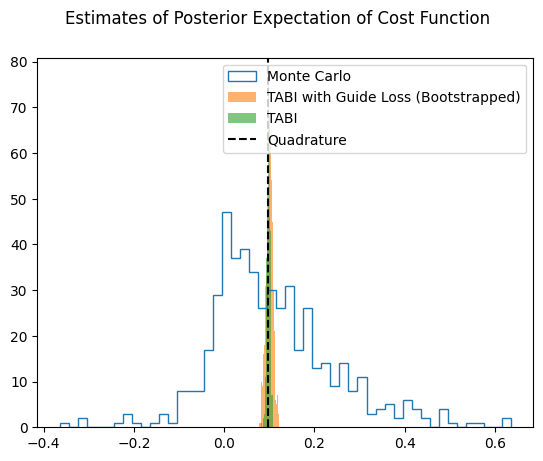

In [17]:
plt.figure()
plt.suptitle("Estimates of Posterior Expectation of Cost Function")
plt.hist(posterior_cost_mc, bins=50, label="Monte Carlo", fill=False, histtype='step')
plt.hist(bootstrap_estimate_with_elbo(losses2, burnin=1500), bins=20, label="TABI with Guide Loss (Bootstrapped)", alpha=0.6)
plt.hist([v.detach() for v in posterior_cost_tabi], bins=20, label="TABI", alpha=0.6)
plt.axvline(posterior_gt[0], color='black', label="Quadrature", linestyle='--')
plt.legend()

# Single-Stage Demonstration

In [18]:
import importlib
import chirho.contrib.compexp as ep
importlib.reload(ep)

<module 'chirho.contrib.compexp' from '/Users/azane/GitRepo/causal_pyro/chirho/contrib/compexp/__init__.py'>

In [19]:
ptlh = ep.ProposalTrainingLossHandler(
    num_samples=N//3,
    lr=6e-3
)

ptlh.register_guides(
        ce=expectation_of_cost_tabi,
        model=conditionable_model,
        auto_guide=AutoNormal,
        auto_guide_kwargs=dict(init_scale=2.0),
        # This prevents the auto_guide from trying to sample observed data.
        auto_guide_model_wrap=lambda m: pyro.poutine.block(m, hide=['y'])
    )

In [20]:
posterior_cost_ss_tabi = []
burnin_scale = 31
with pyro.condition(data=data):

    print(f"Burning in...{ptlh.num_samples * burnin_scale}")
    for _ in range(burnin_scale):
        with ptlh:
            expectation_of_cost_tabi(conditionable_model)

    for _ in range(M):
        with ptlh:
            posterior_cost_ss_tabi.append(
                expectation_of_cost_tabi(conditionable_model)
            )

Burning in...1023


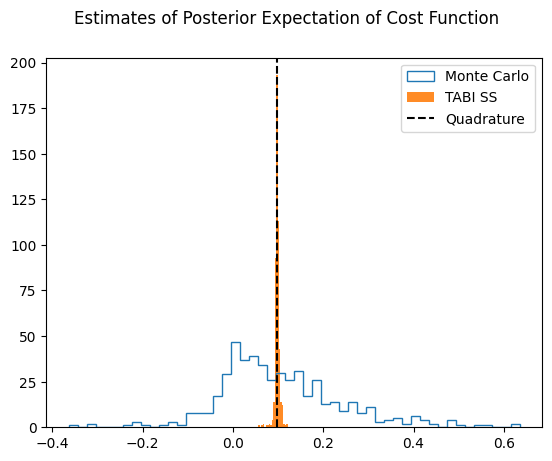

In [21]:
plt.figure()
plt.suptitle("Estimates of Posterior Expectation of Cost Function")
plt.hist(posterior_cost_mc, bins=50, label="Monte Carlo", fill=False, histtype='step')
plt.hist(posterior_cost_ss_tabi, bins=20, label="TABI SS", alpha=0.9)
plt.axvline(posterior_gt[0], color='black', label="Quadrature", linestyle='--')
plt.legend()